In [12]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools
from IPython.display import Image

# PGMPy
from hela.graphical_hmm import DynamicBayesianNetwork as dbn
from hela.graphical_hmm.ContinuousFactor import ContinuousFactor
# from pgmpy.factors.discrete import TabularCPD
import networkx as nx


### HMM Generative Model

In [13]:
generative_model = hmm_gen.DiscreteHMMGenerativeModel(
                                     n_hidden_states =3,
                                     n_gaussian_features=1,
                                    n_categorical_features = 2,
                                     n_gmm_components = None)

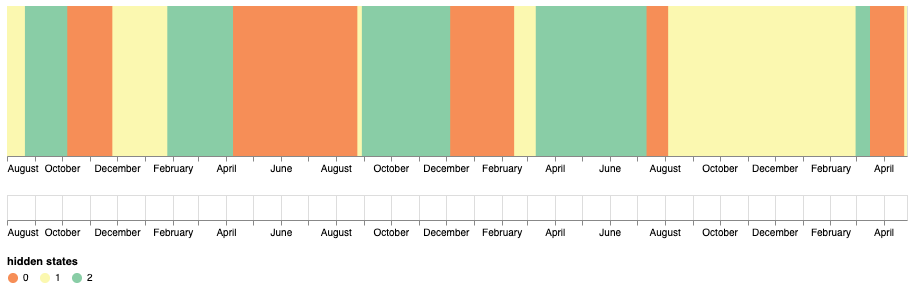

In [14]:
hidden_states = generative_model.generate_hidden_state_sequence(n_observations = 1000)
hmmplot.draw_states(hidden_states, hide_brush=False)

In [15]:
hmm_data = generative_model.generate_observations(hidden_states)
hmm_training_spec = generative_model.generative_model_to_discrete_hmm_training_spec()
model_config = hmm.DiscreteHMMConfiguration.from_spec(hmm_training_spec)
hmm_model = model_config.to_model()

In [16]:
hmm_graph = dbn.hmm_model_to_graph(hmm_model)

In [17]:
for node in hmm_graph.nodes:
    print("latent status for node {} at t = {}: ".format(node[0], node[1]), 
          hmm_graph.nodes[node])

latent status for node hs at t = 0:  {'latent': True}
latent status for node hs at t = 1:  {'latent': True}
latent status for node cont_obs at t = 0:  {'latent': False}
latent status for node cont_obs at t = 1:  {'latent': False}
latent status for node cat_obs at t = 0:  {'latent': False}
latent status for node cat_obs at t = 1:  {'latent': False}


In [18]:
hmm_graph.get_factors(time_slice=0)

[[<TabularCPD representing P(('cat_obs', 0):6 | ('hs', 0):3) at 0x7f84d202c7b8>],
 [<TabularCPD representing P(('hs', 0):3) at 0x7f84d202c860>]]

In [19]:
hmm_graph.get_factors(time_slice=1)

[[<TabularCPD representing P(('cat_obs', 1):6 | ('hs', 1):3) at 0x7f84d202c780>],
 [<TabularCPD representing P(('hs', 1):3 | ('hs', 0):3) at 0x7f84d202c898>]]

In [20]:
# This checks that the CPD tables between edges are valid

hmm_graph.check_model()

True

In [21]:
hmm_graph.edges()

OutEdgeView([(('hs', 0), ('hs', 1)), (('hs', 0), ('cont_obs', 0)), (('hs', 0), ('cat_obs', 0)), (('hs', 1), ('cont_obs', 1)), (('hs', 1), ('cat_obs', 1))])

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


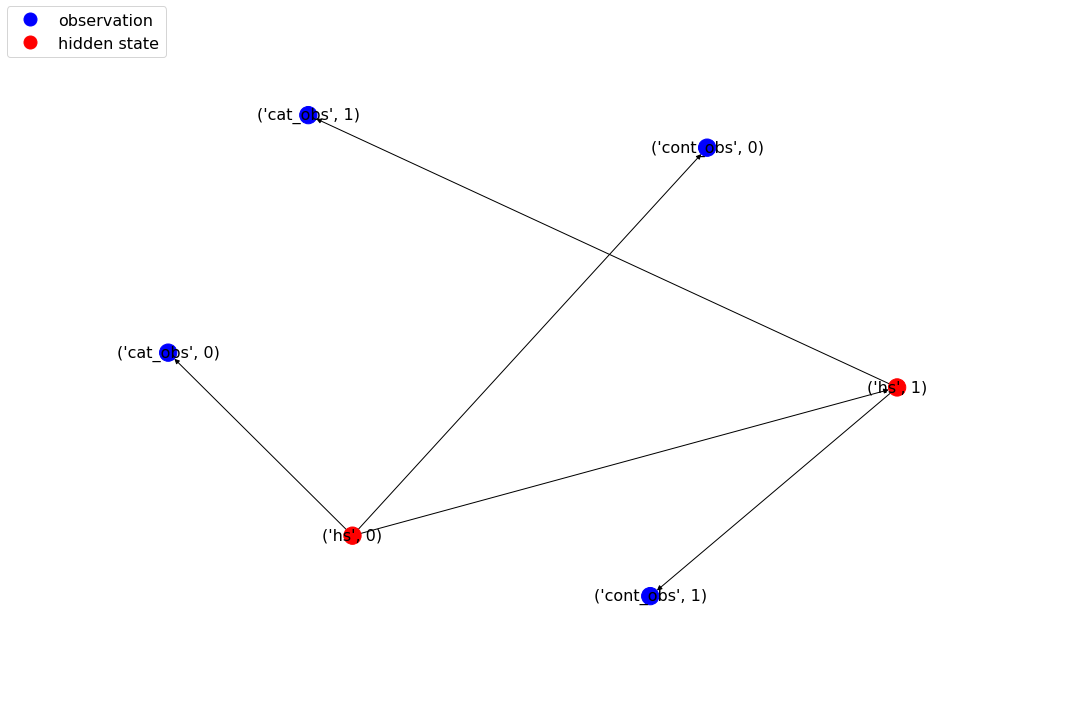

In [23]:
# Initialize Matplotlib figure and set figsize
f = plt.figure(1, figsize = (15,10))
ax = f.add_subplot(1,1,1)
plt.axis('off') # Turn off axis.

pos = nx.spring_layout(hmm_graph, k=5)

color_map = []
for n in hmm_graph.nodes:
    if "hs" in n[0]:
        color_map.append('red')
    else:
        color_map.append('blue')
    
nx.draw_networkx(hmm_graph, 
                 pos = pos, 
                 edge_color = "black", 
                 node_color = color_map,
                 with_labels=True, 
                 font_size = 16, 
                 node_size = 300)

ax.plot([],[],color="blue",label='observation', marker = 'o', markersize = 13, linewidth = 0)
ax.plot([],[],color="red",label='hidden state', marker = 'o', markersize = 13, linewidth = 0)
plt.legend()
plt.legend(loc='upper left', borderaxespad=0, fontsize = 16)
    

ax.set_xlim([1.2*x for x in ax.get_xlim()])
ax.set_ylim([1.2*y for y in ax.get_ylim()])
plt.tight_layout()
    
plt.show()

### FHMM

In [24]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[3, 2],
                                     n_gaussian_features = 1,
                                     n_categorical_features = 2)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 500)

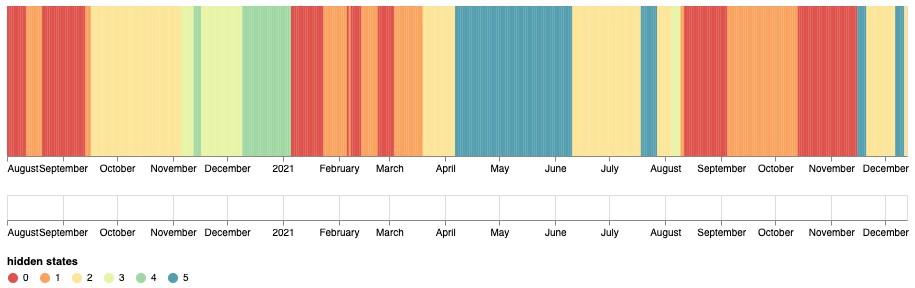

In [25]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

In [26]:
data = gen.generate_observations(factored_hidden_states)
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
                                   gen.ns_hidden_states, 
                                   data,
                                   categorical_features = list(gen.categorical_values.columns), 
                                   gaussian_features = list(gen.gaussian_values.columns))

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)
fhmm_model = fhmm_config.to_model()

In [27]:
fhmm_graph = dbn.fhmm_model_to_graph(fhmm_model)

In [28]:
for node in fhmm_graph.nodes:
    print("latent status for node {} at time step {}: ".format(node[0], node[1]), 
          fhmm_graph.nodes[node])

latent status for node system_0 at time step 0:  {'latent': True}
latent status for node system_0 at time step 1:  {'latent': True}
latent status for node system_1 at time step 0:  {'latent': True}
latent status for node system_1 at time step 1:  {'latent': True}
latent status for node cont_obs at time step 0:  {'latent': False}
latent status for node cont_obs at time step 1:  {'latent': False}
latent status for node cat_obs at time step 0:  {'latent': False}
latent status for node cat_obs at time step 1:  {'latent': False}


In [29]:
fhmm_graph.edges()

OutEdgeView([(('system_0', 0), ('system_0', 1)), (('system_0', 0), ('cont_obs', 0)), (('system_0', 0), ('cat_obs', 0)), (('system_0', 1), ('cont_obs', 1)), (('system_0', 1), ('cat_obs', 1)), (('system_1', 0), ('system_1', 1)), (('system_1', 0), ('cont_obs', 0)), (('system_1', 0), ('cat_obs', 0)), (('system_1', 1), ('cont_obs', 1)), (('system_1', 1), ('cat_obs', 1))])

In [30]:
fhmm_graph.check_model()

True

In [31]:
fhmm_graph.get_factors(time_slice=0)


[[<TabularCPD representing P(('cat_obs', 0):6 | ('system_0', 0):3) at 0x7f84d1e5f320>,
  <TabularCPD representing P(('cat_obs', 0):6 | ('system_1', 0):2) at 0x7f84d1e5f7b8>],
 [<TabularCPD representing P(('system_0', 0):3) at 0x7f84d1e5f860>],
 [<TabularCPD representing P(('system_1', 0):2) at 0x7f84d1e5f978>]]

In [32]:
fhmm_graph.get_factors(time_slice=1)

[[<TabularCPD representing P(('cat_obs', 1):6 | ('system_0', 1):3) at 0x7f84d1e5f390>,
  <TabularCPD representing P(('cat_obs', 1):6 | ('system_1', 1):2) at 0x7f84d1e5fa20>],
 [<TabularCPD representing P(('system_0', 1):3 | ('system_0', 0):3) at 0x7f84d1e5f898>],
 [<TabularCPD representing P(('system_1', 1):2 | ('system_1', 0):2) at 0x7f84d1e5f748>]]

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


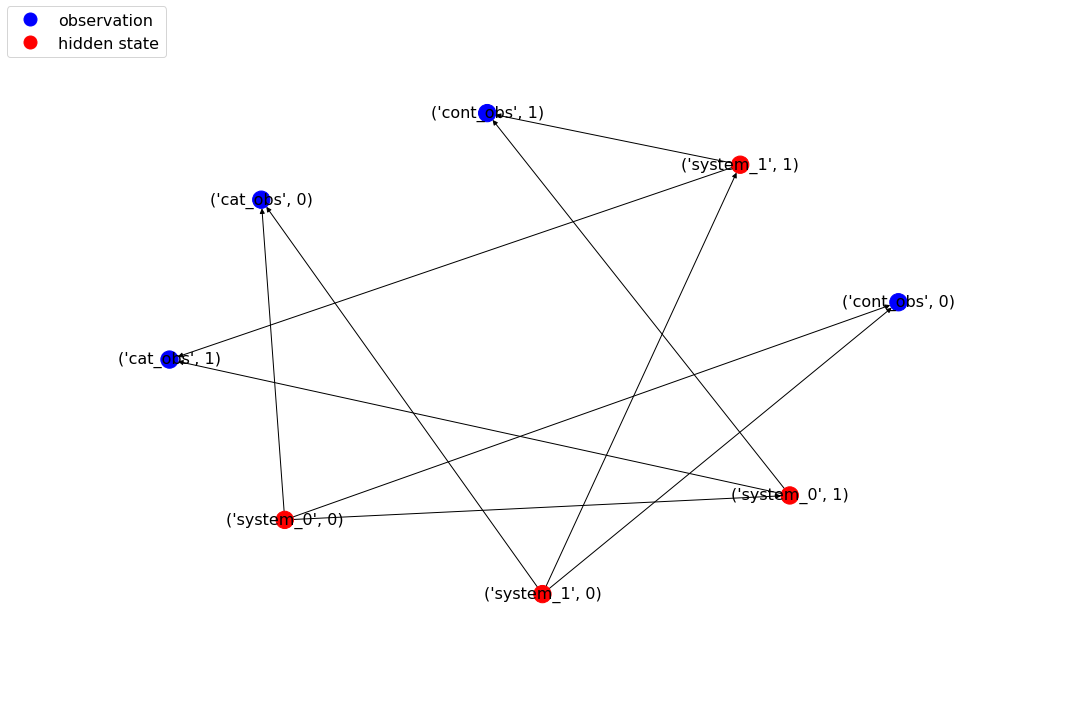

In [33]:
# Initialize Matplotlib figure and set figsize
f = plt.figure(1, figsize = (15,10))
ax = f.add_subplot(1,1,1)
plt.axis('off') # Turn off axis.


pos = nx.spring_layout(fhmm_graph, k=5)

color_map = []
for n in fhmm_graph.nodes:
    if "system" in n[0]:
        color_map.append('red')
    else:
        color_map.append('blue')
    
nx.draw_networkx(fhmm_graph, 
                 pos = pos, 
                 edge_color = "black", 
                 node_color = color_map,
                 with_labels=True, 
                 font_size = 16, 
                 node_size = 300)

ax.plot([],[],color="blue",label='observation', marker = 'o', markersize = 13, linewidth = 0)
ax.plot([],[],color="red",label='hidden state', marker = 'o', markersize = 13, linewidth = 0)
plt.legend()
plt.legend(loc='upper left', borderaxespad=0, fontsize = 16)
    

ax.set_xlim([1.2*x for x in ax.get_xlim()])
ax.set_ylim([1.2*y for y in ax.get_ylim()])
plt.tight_layout()
    
plt.show()